## Introduction

This investigation is to look at historic maximum temperatures in Cheltenham, VIC to see if there is any evidence for climate change.


## Source

Data is sourced from the [BOM](http://www.bom.gov.au/vic/forecasts/melbourne.shtml) for Cheltenham, Victoria.

Direct link to archive of BOM dataset is [here](http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_display_type=dailyZippedDataFile&p_stn_num=086077&p_c=-1481991648&p_nccObsCode=122&p_startYear=1971).

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load CSV Data

In [3]:
data = pd.read_csv(
    'data/IDCJAC0010_086077_1800_Data.csv',
    usecols=['Year', 'Month', 'Day', 'Maximum temperature (Degree C)'])
data[data.Year == 1980].head()

,Year,Month,Day,Maximum temperature (Degree C)
3287,1980,1,1,19.6
3288,1980,1,2,31.4
3289,1980,1,3,33.6
3290,1980,1,4,20.4
3291,1980,1,5,19.3


Extract the year, month and temperature.

In [4]:
# subselect columns
df0 = data[['Year', 'Month', 'Maximum temperature (Degree C)']]
df0.columns = ['year', 'month', 'maximum']
df0, df0.dtypes, df0.columns

(       year  month  maximum
 0      1971      1      NaN
 1      1971      1      NaN
 2      1971      1      NaN
 3      1971      1      NaN
 4      1971      1      NaN
 ...     ...    ...      ...
 18543  2021     10     21.2
 18544  2021     10     25.0
 18545  2021     10     15.4
 18546  2021     10     14.5
 18547  2021     10     19.5
 
 [18548 rows x 3 columns],
 year         int64
 month        int64
 maximum    float64
 dtype: object,
 Index(['year', 'month', 'maximum'], dtype='object'))

Drop missing data:

In [5]:
df1 = df0.dropna(subset=['maximum'])
df1

,year,month,maximum
212,1971,8,13.9
216,1971,8,16.7
217,1971,8,17.7
218,1971,8,15.6
219,1971,8,10.7
...,...,...,...
18543,2021,10,21.2
18544,2021,10,25.0
18545,2021,10,15.4
18546,2021,10,14.5


Group by year and month (`period`):

In [6]:
# group by year & month and calculate that months average maximum temperature
df2 = df1.groupby(['year', 'month'])['maximum'].mean().reset_index()

What are the hottest months?

In [7]:
df2.sort_values('maximum', ascending=False).head()

,year,month,maximum
113,1981,1,29.487097
340,2000,2,29.418519
138,1983,2,29.239286
304,1997,2,29.142308
567,2019,1,29.045161


So, January and February are typically our hottest months. We won't use data further. Instead we will use the maximum annual temperature for plotting the temperature trend.

Get annual maximum tempertures.

In [8]:
# get the hottest month for each year
df3 = df1.groupby(['year'])['maximum'].max().reset_index()
df3.head() , df3.tail()

(   year  maximum
 0  1971     34.6
 1  1972     39.3
 2  1973     40.5
 3  1974     36.8
 4  1975     39.7,
     year  maximum
 46  2017     37.3
 47  2018     42.3
 48  2019     44.2
 49  2020     43.7
 50  2021     40.6)

Show a simplified histogram of annual maximum temperatures for Cheltenham. Here the temperature has been rounded to an integer so we get buckets for our histogram.

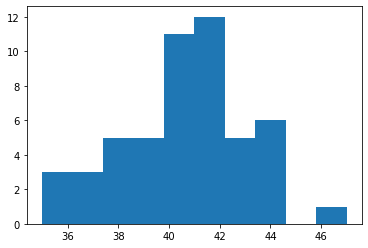

In [14]:
temp_int = df3['maximum'].round(0).astype(int)
plt.hist(temp_int)
plt.show()

Determine the regression line using [linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares) (year ~ maximum temperature):

In [10]:
# prepare linear least squares polynomial fit (returns polynomial coefficients)
pred = np.polyfit(x=df3['year'], y=df3['maximum'], deg=1)
pred

array([ 6.62986425e-02, -9.19026787e+01])

In [11]:
# convert to pandas 1-dimensional polynomial so we can fit to dataframe
temp_pred = np.poly1d(pred)
temp_pred

poly1d([ 6.62986425e-02, -9.19026787e+01])

Append regression to data frame for plotting.

In [12]:
# add new column containing linear regression polynomial
df4 = df3.copy()
df4['prediction'] = temp_pred(df4['year'])
df4.tail()

,year,maximum,prediction
46,2017,37.3,41.821683
47,2018,42.3,41.887982
48,2019,44.2,41.954281
49,2020,43.7,42.020579
50,2021,40.6,42.086878


Plot with regression

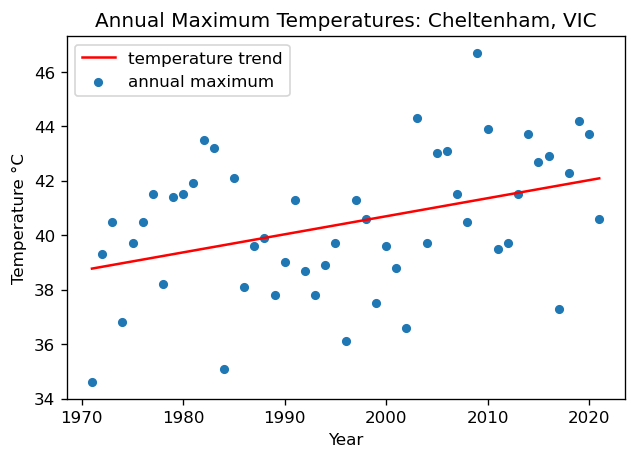

In [13]:
ax = plt.gca() # get current axes
df4.plot(kind='scatter', x='year', y='maximum', label='annual maximum', ax=ax)
df4.plot('year', 'prediction', color='red', label='temperature trend', ax=ax)
plt.title('Annual Maximum Temperatures: Cheltenham, VIC')
plt.xlabel('Year')
plt.ylabel('Temperature °C')
plt.legend()
fig = plt.gcf()
fig.set_dpi(120)
plt.show()